In [1]:
import torch

import matplotlib.pyplot as plt

torch.manual_seed(1)

In [2]:
# hyper parameters，这里就是数据量太小，但是神经元太多的情况，很容易过拟合
N_SAMPLES = 20      #相当于批量为20
N_HIDDEN = 300

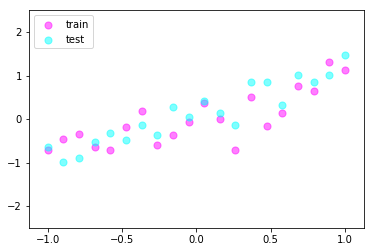

In [16]:
# training data
x = torch.unsqueeze(torch.linspace(-1, 1, N_SAMPLES), 1)            # unsqueeze（..,1）在第'1'位置上增加一个维度,最后维度是（20，1）
y = x + 0.3*torch.normal(mean=torch.zeros(N_SAMPLES, 1), std=torch.ones(N_SAMPLES, 1))  #生成20组正太分布，从每个分布中抽取一个值

# test data
test_x = torch.unsqueeze(torch.linspace(-1, 1, N_SAMPLES), 1)
test_y = test_x + 0.3*torch.normal(mean=torch.zeros(N_SAMPLES, 1), std=torch.ones(N_SAMPLES, 1))

# show data
plt.scatter(x.data.numpy(), y.data.numpy(), c='magenta', s=50, alpha=0.5, label='train')
plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='cyan', s=50, alpha=0.5, label='test')
plt.legend(loc='upper left')
plt.ylim((-2.5, 2.5))
plt.show()

#看下图，希望学出来的曲线，对于train data误差较小，对于test data误差也小，没有overfitting

In [17]:
# 做两个神经网络，第一个会过拟合，第二个不会
net_overfitting = torch.nn.Sequential(
    torch.nn.Linear(1, N_HIDDEN),
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN, N_HIDDEN),
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN, 1),
)

net_dropped = torch.nn.Sequential(
    torch.nn.Linear(1, N_HIDDEN),
    torch.nn.Dropout(0.5),  # drop 50% of the neuron，50%的选取每次都是随机的，这个一般放在激励函数前，也可以放在其后
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN, N_HIDDEN),
    torch.nn.Dropout(0.5),  # drop 50% of the neuron
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN, 1),
)

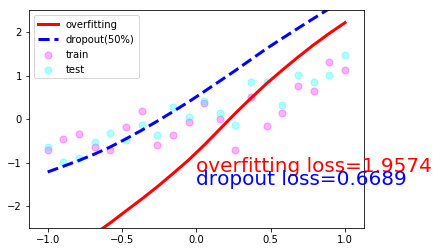

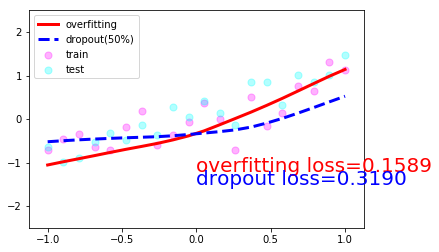

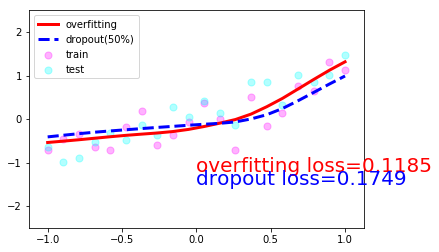

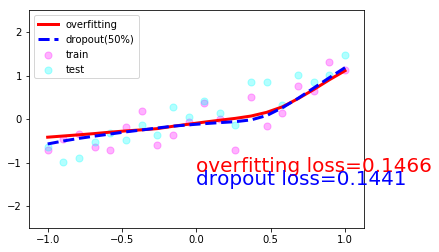

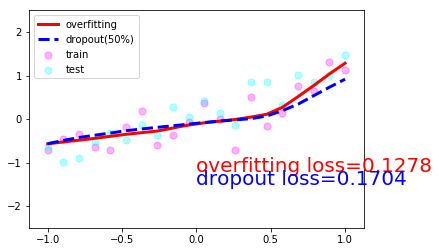

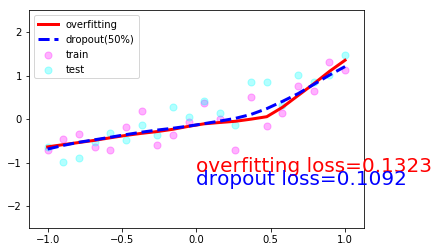

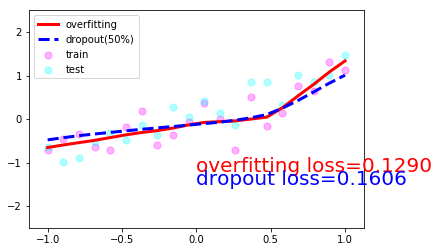

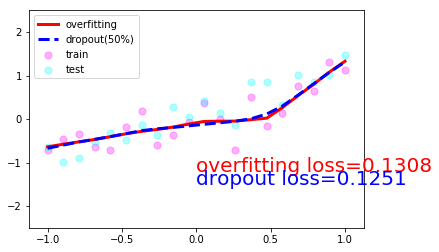

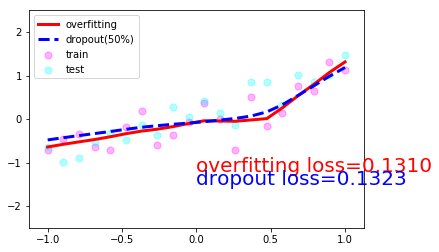

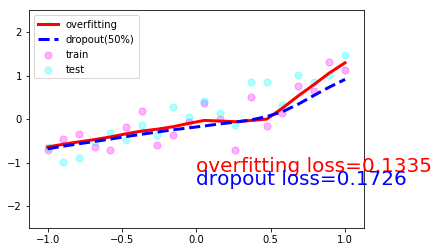

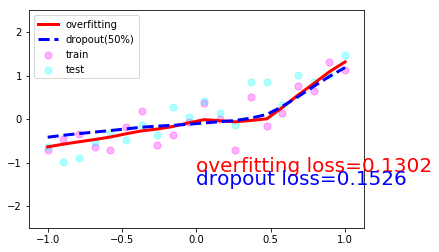

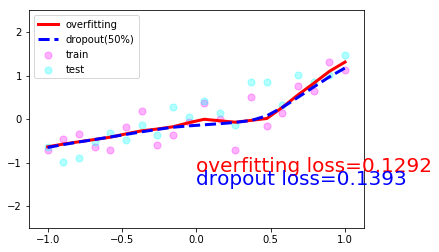

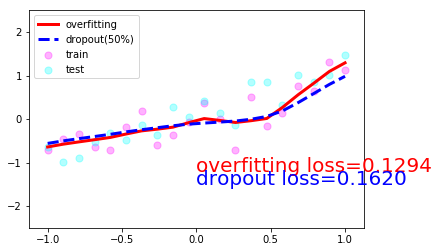

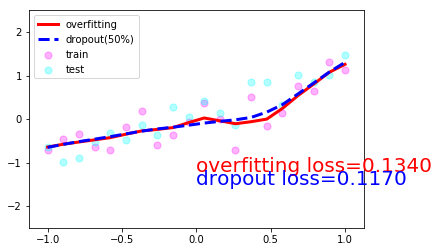

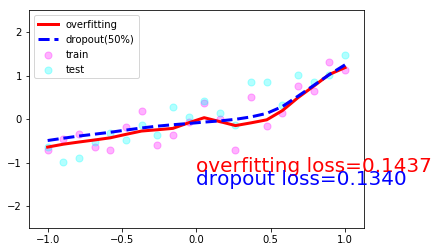

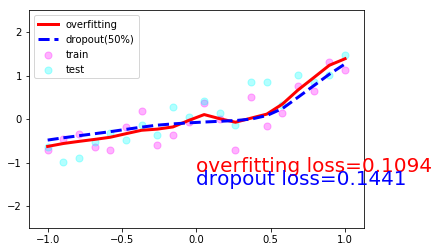

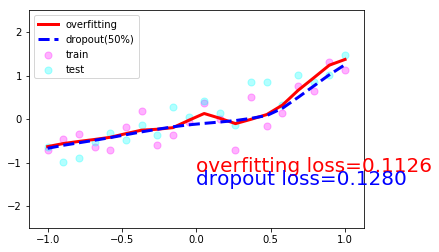

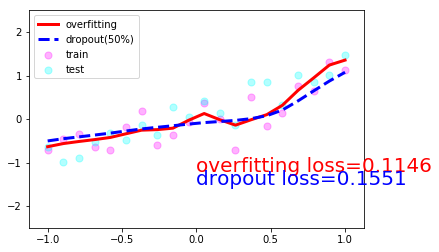

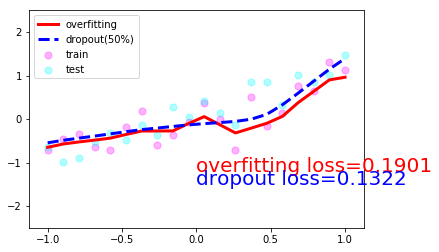

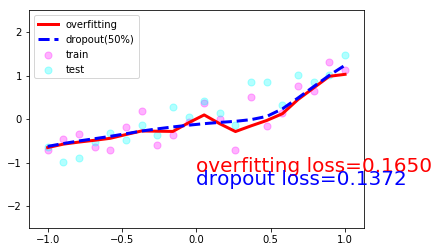

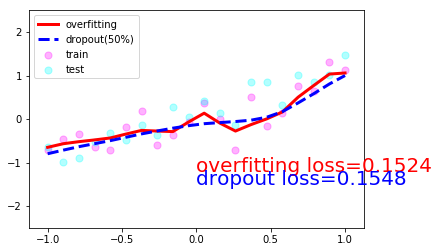

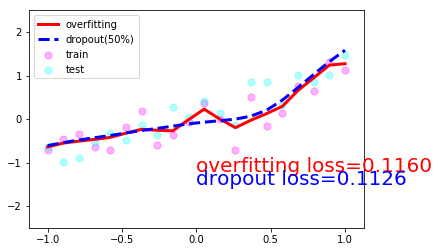

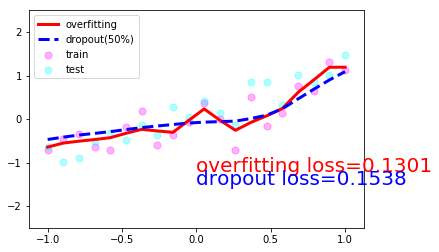

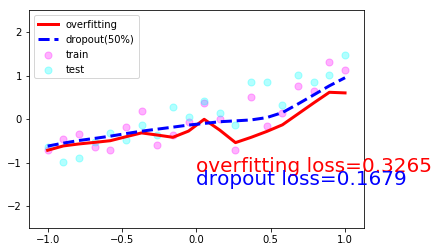

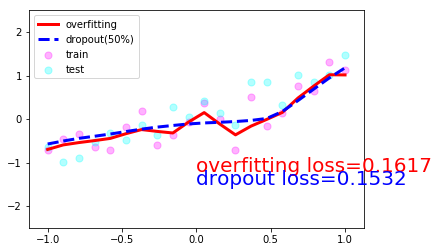

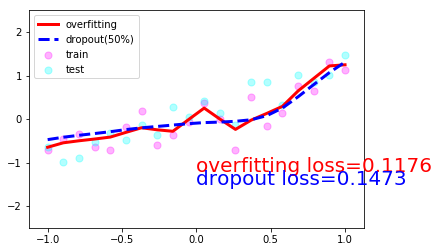

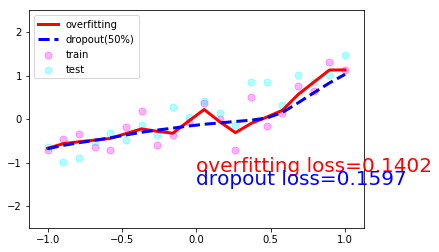

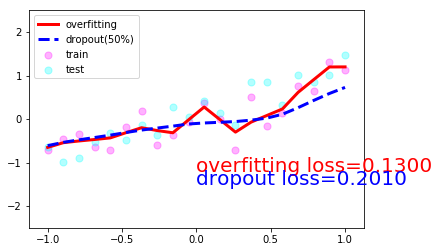

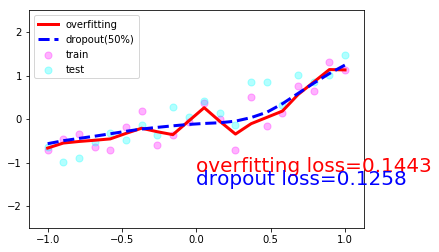

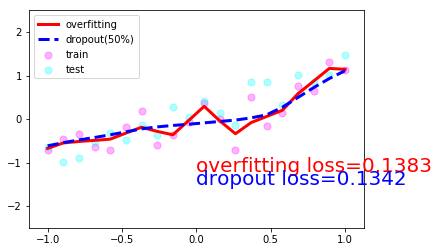

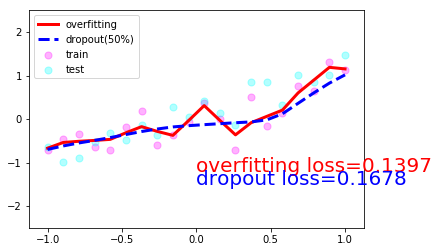

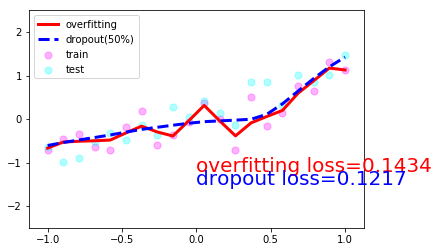

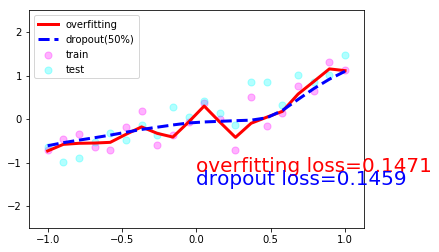

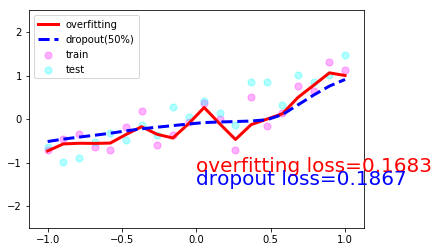

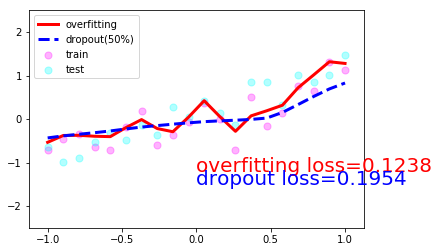

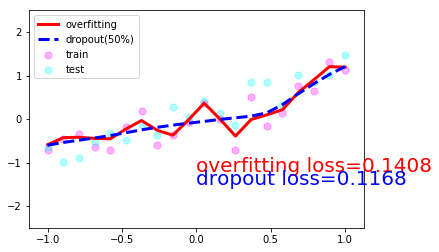

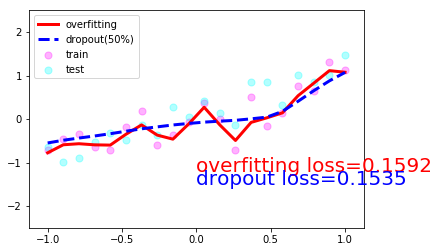

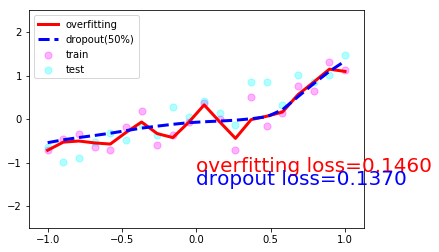

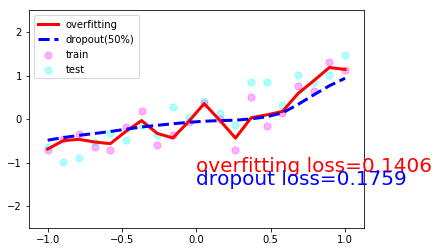

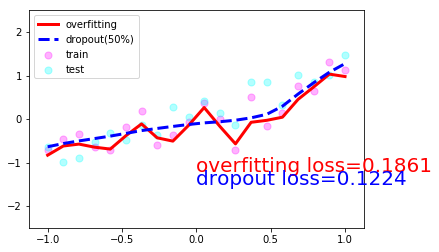

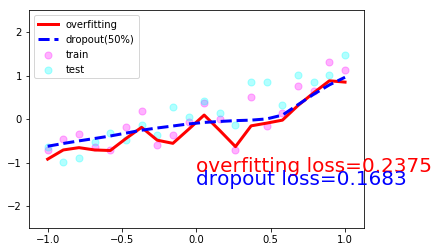

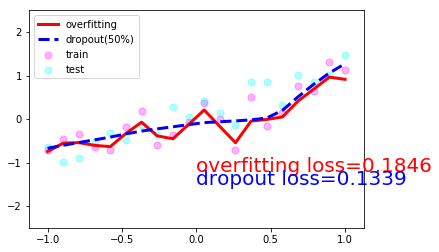

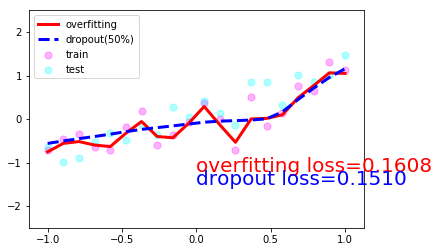

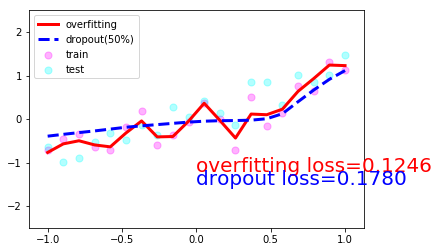

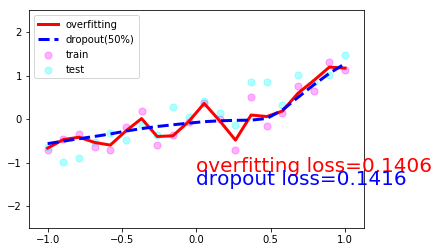

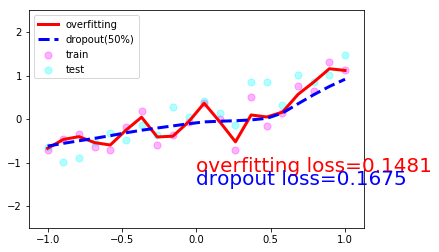

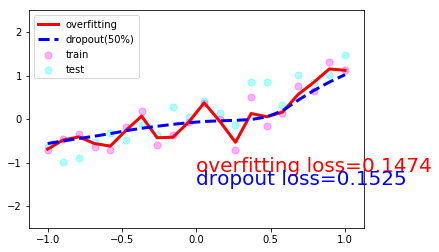

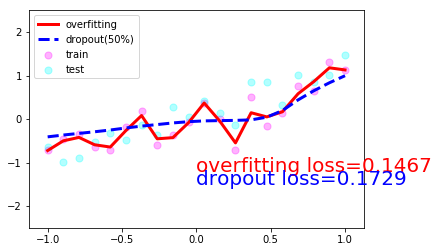

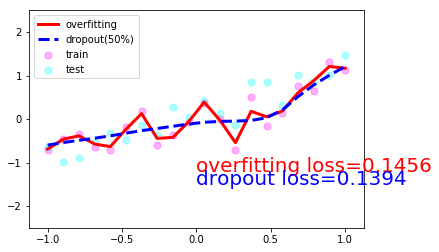

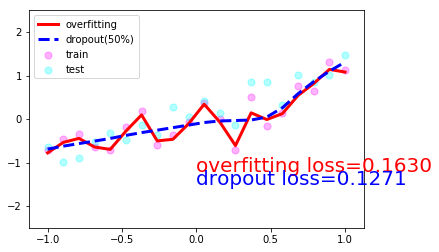

In [18]:
optimizer_ofit = torch.optim.Adam(net_overfitting.parameters(), lr=0.01)
optimizer_drop = torch.optim.Adam(net_dropped.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()

for t in range(500):
    pred_ofit = net_overfitting(x)
    pred_drop = net_dropped(x)
    loss_ofit = loss_func(pred_ofit, y)
    loss_drop = loss_func(pred_drop, y)

    optimizer_ofit.zero_grad()
    optimizer_drop.zero_grad()
    loss_ofit.backward()
    loss_drop.backward()
    optimizer_ofit.step()
    optimizer_drop.step()

    if t % 10 == 0:
        # change to eval mode in order to fix drop out effect， 由于训练的时候dropout，但是预测的时候不需要，
        # 因此pytorch提供在两种模式中切换，预测模式eval和训练模式train
        net_overfitting.eval()
        net_dropped.eval()  # parameters for dropout differ from train mode
        test_pred_ofit = net_overfitting(test_x)
        test_pred_drop = net_dropped(test_x)
        
        # plotting
        plt.cla()
        plt.scatter(x.data.numpy(), y.data.numpy(), c='magenta', s=50, alpha=0.3, label='train')
        plt.scatter(test_x.data.numpy(), test_y.data.numpy(), c='cyan', s=50, alpha=0.3, label='test')
        
        plt.plot(test_x.data.numpy(), test_pred_ofit.data.numpy(), 'r-', lw=3, label='overfitting')
        plt.plot(test_x.data.numpy(), test_pred_drop.data.numpy(), 'b--', lw=3, label='dropout(50%)')
        plt.text(0, -1.2, 'overfitting loss=%.4f' % loss_func(test_pred_ofit, test_y).data.numpy(), fontdict={'size': 20, 'color':  'red'})
        plt.text(0, -1.5, 'dropout loss=%.4f' % loss_func(test_pred_drop, test_y).data.numpy(), fontdict={'size': 20, 'color': 'blue'})
        plt.legend(loc='upper left'); plt.ylim((-2.5, 2.5));plt.pause(0.1)

        # change back to train mode
        net_overfitting.train()
        net_dropped.train()

plt.ioff()
plt.show()